## Time Series Analysis and Forecasting of Historical Daily Prices of Gold (price per ounce in USD)

## Project Description
#### Time series data is defined as an ordered sequence of temporal values of a quantitative variable at equally spaced time intervals. Such data are usually collected and gathered when monitoring industrial processes or tracking corporate business metrics. Values are quantitative and measured sequentially in time over some interval. Time series analysis has been exploited for many applications, e.g., sales forecasting, economic forecasting, budgetary analysis, yield projections, stock market analysis, census analysis, process, and quality control, inventory studies, workload projections, utility studies (<i>Pant, Anjali and Rajput, R.. (2019). Time Series Analysis of Gold Price Using R)</i>.

#### Time series Analysis is one of the most applied Machine Learning and Data Science techniques in various businesses and industriesuch as retail, financial, supply chain management, agricultural and many more. However, Machine learning for time series is not as known or popularly discussed as others. Techniques such as pattern recognition, object recongnition, speech recognition and natural language processing, often garner more attention in the Data Science world.

## Expected outcome
#### Our prediction task was to forecast the monthly average gold prices from August 2020 to August 2021, taking the data from January 2017 - July 2020 as input.

#### There are several forecasting techniques available, based on varying assumptions, mathematical hypothesis and model parameters. For better forecasting result, it is important to find the appropriate technique and the best-fit model for a given time series data. In our project, we first analysed our time series data, considering the nature and structure of it, then developed various models using different methodologies in an attempt to find the model best-suited for our dataset.

#### Dataset was downloaded from https://www.kaggle.com/datasets/lbronchal/gold-and-silver-prices-dataset?select=gold_price.csv

In [1]:
#set up imports...
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import numpy as np
from statsmodels.tsa.api import Holt, ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools

# Set the default figure style
#plt.style.use('./d4sci.mplstyle')

%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')

# PART ONE: TIME SERIES ANALYSIS AND PROCESSING

## Getting to know our Dataset
 - Historical daily prices of gold and silver since 1962 to now.
 - Price per ounce in USD.
 
 
 Good data preparation also makes it easier to make adjustments and find ways to improve your model’s fit, as well as research potential questions about the results.

In [3]:
# Import the data
df = pd.read_csv("gold_price_2017_2020.csv")
df['date'] = pd.to_datetime(df['date'])
# Set the date as index 
df = df.set_index('date')
# Select the proper time period for weekly aggreagation
df = df['2017-01-03':'2020-07-31'].resample('W').sum()
df

,price
date,
2017-01-08,4667.80
2017-01-15,5941.95
2017-01-22,6030.40
2017-01-29,5999.20
2017-02-05,6046.40
...,...
2020-07-05,8861.10
2020-07-12,9003.75
2020-07-19,9029.05


In [4]:
display(df.shape)
display(df.isnull().sum())

(187, 1)

price    0
dtype: int64

#### Our dataset has no null values after resampling to a higher scale. 

### Examining and Preparing our Dataset, prior to Modeling
#### As part of the Time Series (TS) Analysis steps, we need to check our data for common Time Series patterns, especially the ones that can affect our result or introduce bias into our predictions. This step will also help us determine what type of forecasting model is suitable for our data.

#### Common time series data components/patterns are:
 - Trend	Increases, decreases, or stays the same over time
 - Seasonal or Periodic	Pattern repeats periodically over time
 - Cyclical	Pattern that increases and decreases but usually related to non-seasonal activity, like business cycles
 - Random or Irregular Variations	Increases and decreases that don’t have any apparent pattern
 
#### Most TS datasets will contain one or more of these patterns. 

### We will use Visualization and Decomposition to find Trends, Seasonality, Cyclic fluctuations and Random Variations in our data:

## Visualization

#### The first step is simply to plot the dataset, using the matplotlib package. Since it’s easier to To see a general trend using the mean of all our data, we use both the original data points (blue line) and the monthly average resampled data (purple line). 

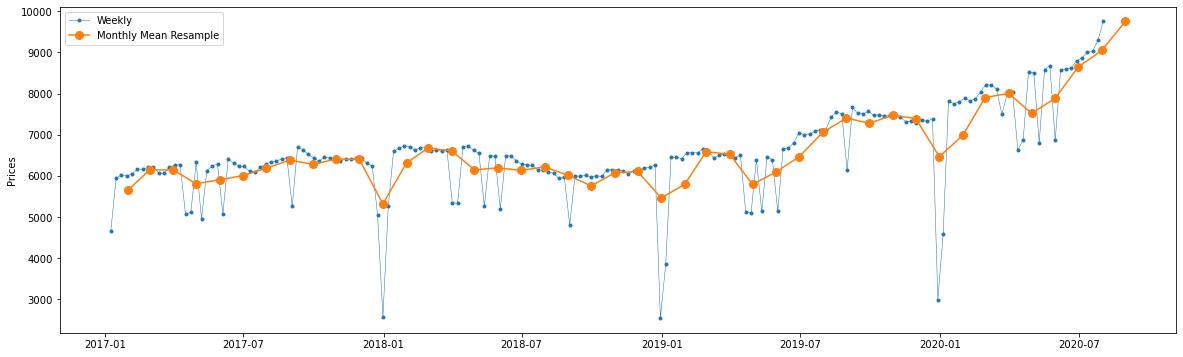

In [5]:
y = df['price']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Prices')
ax.legend();

#### This graphs gives us somewhat an idea of what data we are dealing with. The up/down patterns shows that gold price dips at certain "seasons" during the year (an example is a clear dip at the beginning of every year), but generally appears to have an increasing trend year-on-year. We note a sharp dip in average prices around the beginning of every yearmid-2021 which is clear indication of an irregular variation. From what we know, this could likely be as a result of the global pandemic brought on by COVID-19.

#### To further understand strange anomalies, we can reach out Subject Matter Experts in this area who can provide us with better insights and possible causes.

## Data Decomposition
#### Next, we decompose the data to gain better understanding of what our linear visualization has shown us. . A useful Python function called seasonal_decompose within the 'statsmodels' package can help us to decompose the data into four different components:
 - <i>Observed</i>
 - <i>Trended</i>
 - <i>Seasonal</i>
 - <i>Residual</i>

### Seasonality Decomposition

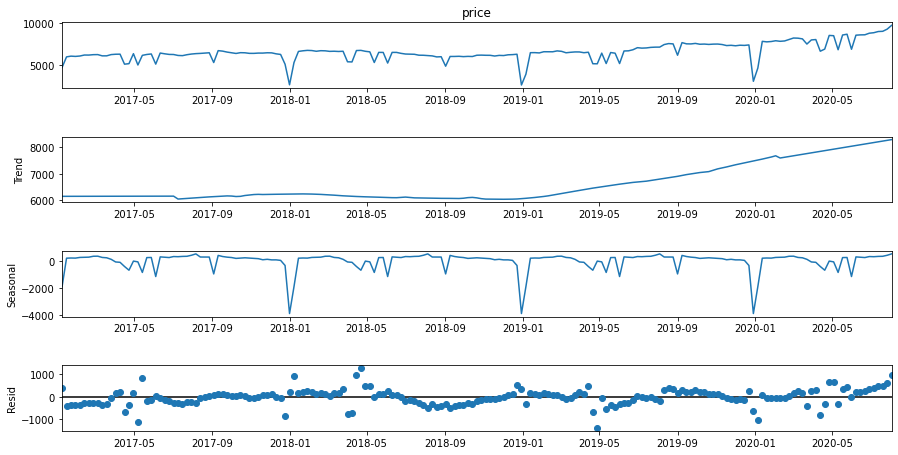

In [6]:
# graphs to show seasonal_decompose
season_decompose = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
fig = season_decompose.plot()
fig.set_size_inches(14,7)
plt.show()

#### From the decomposed graphs above, we can tell that our gold price dataset has an overall increasing trend year-on-year, as well as a yearly seasonality. These peices of information will become very relevant further on, when we need to decide on our choice of forecasting model.

## Checking for Stationarity

#### Stationarity is a very important concept in time series analysis that may help increase the predictive power of our machine learning algorithms. When a Time Series is said to be stationary, it means that it's statistical parameters (mean, variance, autocorrelation) do not change over time.


#### Time series data related to economic activities are usually non-stationary due to elements like trends and cycles, but forecasting models use mathematical algorithms and transformation related to stationarity, we will need to ‘stationarize’ our time series data as part of the process of fitting a model. This is especially important in order for us to receive accurate and consistent forecasted results when we make predictions.

### We will use the following methods to check the stationarity of our data:
 - Visualization: Here, we create graphs of the rolling statistics (mean and variance) to show whether the standard deviation changes substantially over time.
 
 - Augmented Dickey-Fuller (ADF) Test: This is statistical significance test that compares the p-value with the critical values, and also performs hypothesis testing. With this test, we can determine whether the processed data is stationary or not with varying levels of confidence.

#### Python provides functions and packages to do these easily:

In [7]:
# we write a re-usable function that we will call whenever needed
def check_stationarity(variable, title):
    
    #Determing rolling statistics
    mean = pd.Series(variable).rolling(window=12).mean() 
    std = pd.Series(variable).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(variable, label= title)
    ax.plot(mean, label='rolling mean');
    ax.plot(std, label='rolling std (x10)');
    ax.legend()
pd.options.display.float_format = '{:.8f}'.format

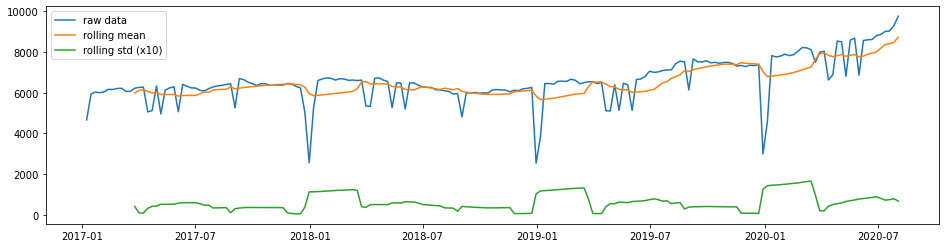

In [8]:
check_stationarity(y,'raw data')

#### As mentioned previously,the mean and standard deviation for a stationary dataset should remain constant over time. From the plot above, we can almost confidently say that our dataset does not appear stationary, but because our variable has a large scale, we will do another stationary test to back up our hunch:

In [9]:
# we write a re-usable function that we will call whenever needed
def ADF_test(variable, desc):
    print(':::Checking our {} for Stationarity:::'.format(desc))
    dftest = adfuller(variable.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {}  - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [10]:
ADF_test(y,'raw data')

:::Checking our raw data for Stationarity:::
Test statistic = -1.723
P-value = 0.419
Critical values :
	1%: -3.4668001583460613  - The data is not stationary with 99% confidence
	5%: -2.8775552336674317  - The data is not stationary with 95% confidence
	10%: -2.5753075498128246  - The data is not stationary with 90% confidence


#### Looking at both the visualization and ADF test, we can tell that our sample gold price data is non-stationary. Our visual hunch was right!

## Stationarising Our Dataset

#### To proceed with our time series analysis, we need to stationarize the dataset. The approaches we will use to do this are:
 - <i>Differencing</i>
 - <i>De-Trending</i>
 - <i>Combination of both</i>

#### Differencing
Differencing is used to remove seasonal or cyclical fluctuations in the time series. It uses lagged values to determine how many times to do the differencing on the data before it is used in model. Because our time series data appears to have a yearly ( 12-month) seasonality, we will use a 12-lag difference, after which we will perform the ADF testing again:

:::Checking our 12 lag differenced data for Stationarity:::
Test statistic = -2.806
P-value = 0.057
Critical values :
	1%: -3.4718957209472654  - The data is not stationary with 99% confidence
	5%: -2.8797795410156253  - The data is not stationary with 95% confidence
	10%: -2.5764947265625  - The data is  stationary with 90% confidence


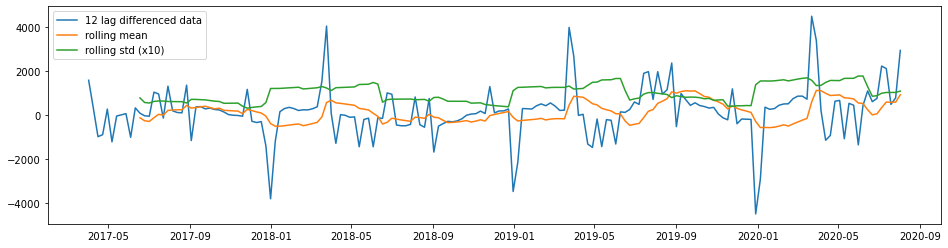

In [11]:
y_lagged =  y - y.shift(12)

check_stationarity(y_lagged,'12 lag differenced data')
ADF_test(y_lagged,'12 lag differenced data')

##### Differencing did not work so well for our data, as indicated by the ADF test which is not stationary within 99 percent of the confidence interval. 
We will try De-trending next, to see if we get a better result:

#### De-trending
This method is used to remove the underlying trend in the time series and render it stationary:

:::Checking our de-trended data for Stationarity:::
Test statistic = -9.370
P-value = 0.000
Critical values :
	1%: -3.4682803641749267  - The data is  stationary with 99% confidence
	5%: -2.8782017240816327  - The data is  stationary with 95% confidence
	10%: -2.5756525795918366  - The data is  stationary with 90% confidence


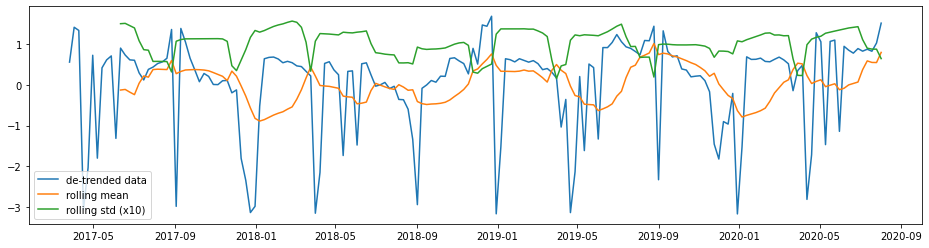

In [12]:
detrended =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

check_stationarity(detrended,'de-trended data')
ADF_test(detrended,'de-trended data')

#### The results show that the data is now stationary, after running the ADF test again.
##### De-trending worked great to stationarise our dataset, but can we get even better result when we use a combination of differencing and de-trending? Well, let's try it and see:

#### Combining Detrending and Differencing

:::Checking our 12-lagged differenced de-trended data for Stationarity:::
Test statistic = -4.182
P-value = 0.001
Critical values :
	1%: -3.4744158894942156  - The data is  stationary with 99% confidence
	5%: -2.880878382771059  - The data is  stationary with 95% confidence
	10%: -2.577081275821236  - The data is  stationary with 90% confidence


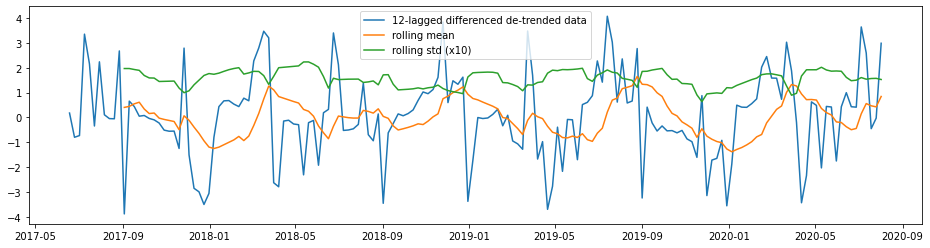

In [13]:
y_lagged_detrended =  detrended - detrended.shift(12)

check_stationarity(y_lagged_detrended,'12-lagged differenced de-trended data')
ADF_test(y_lagged_detrended,'12-lagged differenced de-trended data')

##### We see from both the visualization and the test statistic from the ADF test that our data now has even better stationarity using the combination of both methods. We will therefore use this transformation for the rest of our analysis and forecasting.

# 

# PART TWO: MODEL SELECTION, TRAINING AND EVALUATION

## Create Training & Testing Data
#### We need to divide our dataset into 2 parts: 1 part to train our forecast model, and the other part to test/evaluate the efficiency of our model. Commonly, we split our data into -  80% for training and 20% for testing.

In [14]:
X = y
size = int(len(X) * 0.80)
y_to_train, y_to_test = X[0:size], X[size:len(X)]
forecast_steps = len(X) - len(y_to_train) # the number of data points for the test set

In [15]:
print(y.shape)
print(y_to_train.shape)
print(y_to_test.shape)
print(forecast_steps) 

(187,)
(149,)
(38,)
38


## Choosing a Time Series Model
#### Now that we have our training and testing data, we will choose the best model for our dataset. We will try out four different forecasting models, and then select the best suited model for our time series:
 - <i>Holt’s Linear Trend Method (a.k.a Double Exponential Smoothing)</i>: best suited for data with a trend but no seasonality
 - <i>Holt-Winters’ Seasonal Method</i>: best suited for data with trend and/or seasonality
 - <i>SARIMA</i>: best suited for data with trend and/or seasonality

### Holt’s Linear Trend Method (a.k.a Double Exponential Smoothing)

#### Although we know our time series has both trend and seasonality components, but for comparison, we will go ahead and create a forecasting model using the Holt’s Linear Trend method,also known as the Double Exponential Smoothing) method which is best suited for data that has trend but no seasonality. Holt’s linear trend method uses the same α parameter as the Simple Exponential Smoothing model, but also adds β*, which is the smoothing factor for trend. Like α, β* also have a value range of 0-1.

##### We will model 3 variants of Holt's:
 - Holt's linear(additive) model (usually the default), and
 - Holt's exponential model (best suited for where changes/movements initially starts slowly, but then speeds up exponentially, and
 - Holt's additive damped-trend model

In [16]:
def holt_method(y,y_to_train,y_to_test,smoothing_level,smoothing_trend, forecast_steps):
    #y.plot(marker='o', color='royalblue', legend=True, figsize=(18, 9))
    
    fit1 = Holt(y_to_train).fit(smoothing_level, smoothing_trend, optimized=False)
    fcast1 = fit1.forecast(forecast_steps).rename("Holt's linear(additive) trend")
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('*** RMSE of Holt''s Linear trend {}'.format(round(np.sqrt(mse1), 2)))

    fit2 = Holt(y_to_train, exponential=True).fit(smoothing_level, smoothing_trend, optimized=False)
    fcast2 = fit2.forecast(forecast_steps).rename("Holt's exponential trend")
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('*** RMSE of Holt''s Exponential trend {}'.format(round(np.sqrt(mse2), 2)))
    
    fit3 = Holt(y_to_train, damped_trend=True, initialization_method="estimated").fit(smoothing_level, smoothing_trend)
    fcast3 = fit3.forecast(forecast_steps).rename("Holt's additive damped trend")
    print('*** RMSE of Holt''s Additive Damped trend {}'.format(round(np.sqrt(mse2), 2)))
    
    #fit1.fittedvalues.plot(marker="o", color='lime')
    #fit2.fittedvalues.plot(marker="o", color='indianred')
    #fit3.fittedvalues.plot(marker="o", color='purple')
    #fcast1.plot(marker="o", color='lime', legend=True)
    #fcast2.plot( marker="o", color='indianred',legend=True)
    #fcast3.plot( marker="o", color='purple',legend=True)
    
    plt.figure(figsize=(20, 10))
    (line0,) = plt.plot(y, marker="o", color="goldenrod")
    plt.plot(fit1.fittedvalues, color="blue")
    (line1,) = plt.plot(fcast1, marker="o", color="blue")
    plt.plot(fit2.fittedvalues, color="red")
    (line2,) = plt.plot(fcast2, marker="o", color="red")
    plt.plot(fit3.fittedvalues, color="green")
    (line3,) = plt.plot(fcast3, marker="o", color="green")
    plt.legend([line0, line1, line2, line3], ['price', fcast1.name, fcast2.name, fcast3.name])

*** RMSE of Holts Linear trend 1213.65
*** RMSE of Holts Exponential trend 1163.66
*** RMSE of Holts Additive Damped trend 1163.66


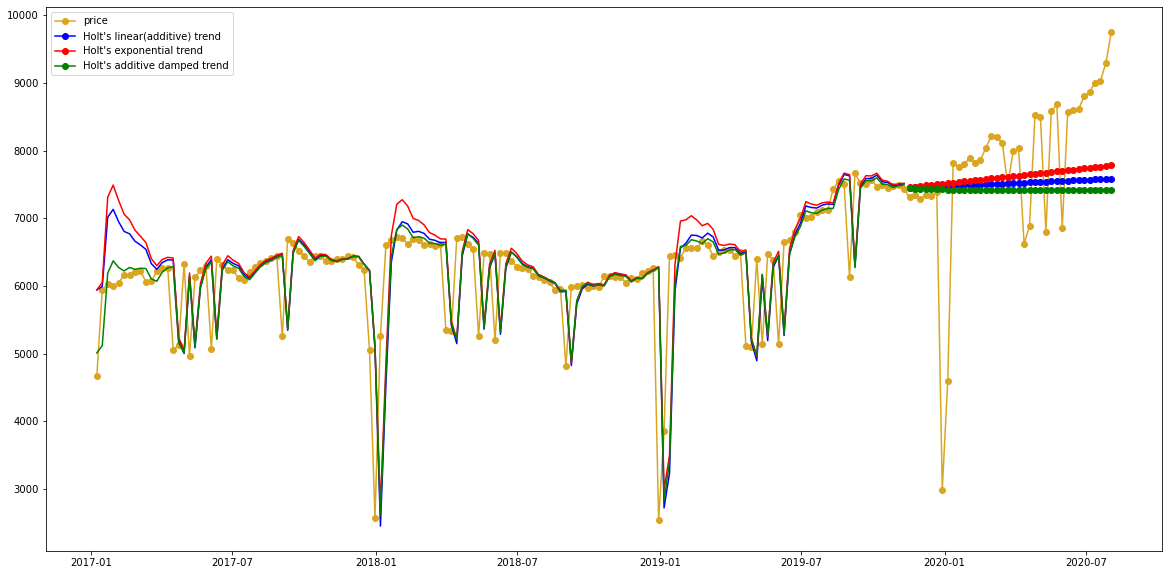

In [17]:
# using α = 0.8, β* = 0.2 
holt_method(y, y_to_train,y_to_test,0.8,0.2,forecast_steps)

#### Analysing our plots above, we see how the linear trend(blue line), exponential trend(red line) and the additive dampened-trend(green line) compare to each other and to the actual gold prices. Holt captures the trend, but it does not quite account for the mid-year seasonl fluctuations we know exists.

### Holt-Winters’ Seasonal Method

#### We know this method works great for data that has trends and/or seasonality components, so we are hopeful that we will get better predictions with it. It includes a seasonality smoothing parameter denoted as 'γ'. There are two types of seasonalities that can be modeled with this method: 
 1. Additive - Here, the Seasonality in the time series stay roughly the same over time. The formula to depict this is:
  - 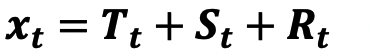
 2. Multiplicative - Here, seasonal variation fluctuates when the overall data changes i.e. when data trends upward, the seasonal variations will also increase proportionally:
  - 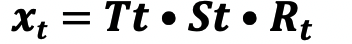

#### Our time series shows a clear yearly seasonal pattern, which we have aggregated into a weekly scale, therefore our frequency (m) will be 52.

#### First, we need to figure out if we are dealing with an additive seasonality or a multiplicative seasonality:

In [18]:
def holt_winter_method(y,y_to_train,y_to_test,s_type,s_period,predict_date):
    
    y.plot(marker='o', color='forestgreen', legend=True, figsize=(20, 10))
    
    if s_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = s_period, trend='add', seasonal='add', use_boxcox=True).fit()
        fcast1 = fit1.forecast(predict_date).rename('Holt-Winters (add-add-seasonal)')
        mse1 = ((fcast1 - y_to_test) ** 2).mean()
        print('*** RMSE of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(s_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = s_period, trend='add', seasonal='add', damped=True, use_boxcox=True).fit()
        fcast2 = fit2.forecast(predict_date).rename('Holt-Winters (add+damped-mul-seasonal)')
        mse2 = ((fcast2 - y_to_test) ** 2).mean()
        print('*** RMSE of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(s_period,round(np.sqrt(mse2), 2)))
        
        fit1.fittedvalues.plot(style='--', color='red')
        fit2.fittedvalues.plot(style='--', color='blue')
        fcast1.plot(style='--', marker='o', color='red', legend=True)
        fcast2.plot(style='--', marker='o', color='blue', legend=True)
    
    elif s_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = s_period, trend='add', seasonal='mul', use_boxcox=True).fit()
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - y_to_test) ** 2).mean()
        print('*** RMSE of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(s_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = s_period, trend='add', seasonal='mul', damped=True, use_boxcox=True).fit()
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        mse4 = ((fcast3 - y_to_test) ** 2).mean()
        print('*** RMSE of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(s_period,round(np.sqrt(mse4), 2)))
        
        fit3.fittedvalues.plot(style='--', color='red')
        fit4.fittedvalues.plot(style='--', color='blue')
        fcast3.plot(style='--', marker='o', color='red', legend=True)   
        fcast4.plot(style='--', marker='o', color='blue',legend=True)
        
    plt.show()

*** RMSE of additive trend, additive seasonal of period season_length=52 and a Box-Cox transformation 928.49
*** RMSE of additive damped trend, additive seasonal of period season_length=52 and a Box-Cox transformation 1005.8


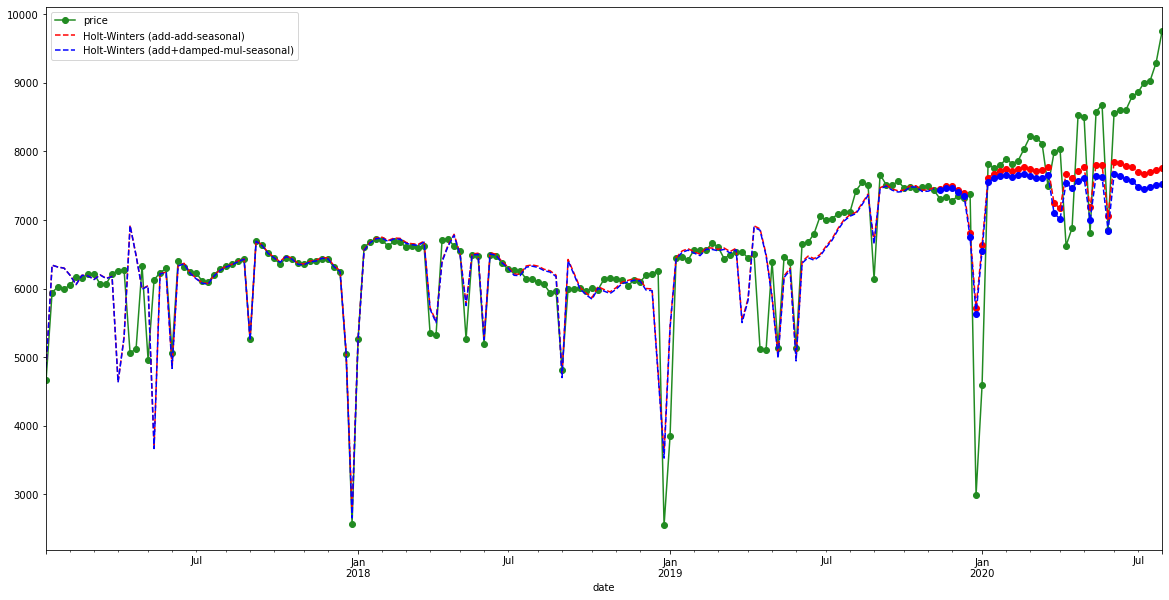

In [19]:
holt_winter_method(y, y_to_train,y_to_test,'additive',52, forecast_steps)

#### Based on our visualization, we see that the Holt-Winters model so far fits our time series best. It also has the lowest RMSE values of all the 3 models we have tried. We can however see that our forecast values begin to drop below the actuals (although still following the trend) towards the end.

## SARIMA

#### Seasonal Autoregressive Integrated Moving Average (also known as Seasonal ARIMA) is an extension of the ARIMA model that supports univariate time series data with a seasonal component. A seasonal ARIMA model is formed by including additional seasonal terms in the ARIMA model. The seasonal part of the model consists of terms that are very similar to the non-seasonal components of the model, but they involve backshifts of the seasonal period (<i>Hyndman, Rob J, and George Athanasopoulos.Forecasting: principles and practice</i>).

#### While exponential smoothing models use weighted averages of past observations to forecast new values, Auto-Regressive Integrated Moving Average or ARIMA models look at autocorrelations or serial correlations in the data. It includes an additional parameter for the seasonality period as well as three new hyperparameters to determine the autoregression (AR), differencing (I), and moving average (MA) for the seasonal component of the series and all these new parameters can be tuned for optimised forcasting.

### SARIMA Hyperparameter Tuning
#### We need to find the values of SARIMA(p,d,q) that optimize a metric of interest, in order to get the best predictions. We will use a "grid search" to iteratively explore different combinations of parameters, using the Akaike Information Criterion(AIC). The AIC measures how well a model fits the data while taking into account the overall complexity of the model. Our aim is ti ultimately select the combination of parameters that produces the lowest AIC value.

In [24]:
def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    mini = float('+inf')

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
                results = mod.fit(disp=0)
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [25]:
sarima_grid_search(y,52)

The set of parameters with the minimum AIC is: SARIMA(1, 1, 1)x(0, 1, 1, 52) - AIC:1211.6641657428306


#### After testing all possible combinations of variables, the grid search returned the lowest AIC value as: <b>SARIMA(1, 1, 1)x(1, 1, 0, 52)</b>. We will use this value to fit our model and compare the results with all the previous models discussed above.


The dynamic=False argument ensures that we produce one-step-ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point. Unfortunately, this is a function that can only be built inside the SARIMA and ARIMA packages, so we cannot print out the same results for the other models we have considered.

In [20]:
def evaluate_sarima(y,order,seasonal_order,seasonal_period,prediction_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_invertibility=False)

    results = mod.fit(disp=0)
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(20, 12))
    plt.show()
    
    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # Here we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(prediction_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('*** RMSE of SARIMA with season_length={} and dynamic = True  --> {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(20, 10))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')

    plt.legend()
    plt.show()
    
    # For comaprison, we will also set dynamic=False ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(prediction_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('*** RMSE of SARIMA with season_length={} and dynamic = False  --> {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(20, 10))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    plt.legend()
    plt.show()

    
    return (results)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1986      0.103      1.921      0.055      -0.004       0.401
ma.L1         -0.7895      0.084     -9.348      0.000      -0.955      -0.624
ar.S.L52      -0.3278      0.069     -4.762      0.000      -0.463      -0.193
sigma2      2.454e+05   2.48e+04      9.904      0.000    1.97e+05    2.94e+05


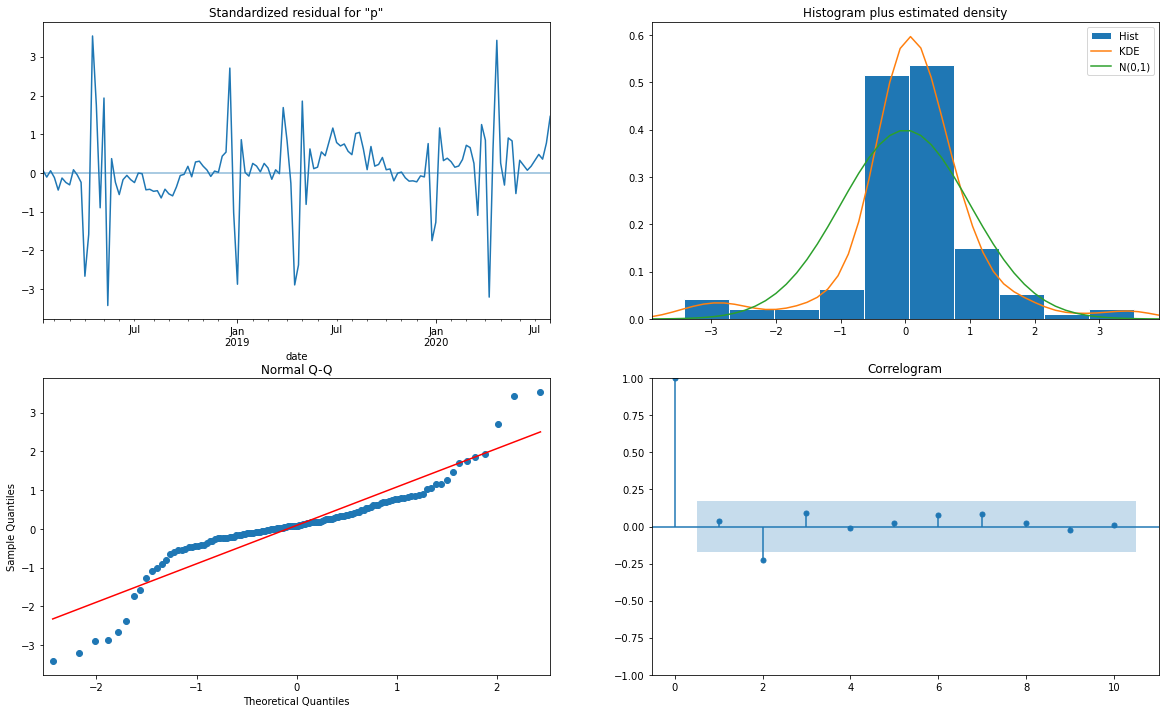

*** RMSE of SARIMA with season_length=52 and dynamic = True  --> 711.75


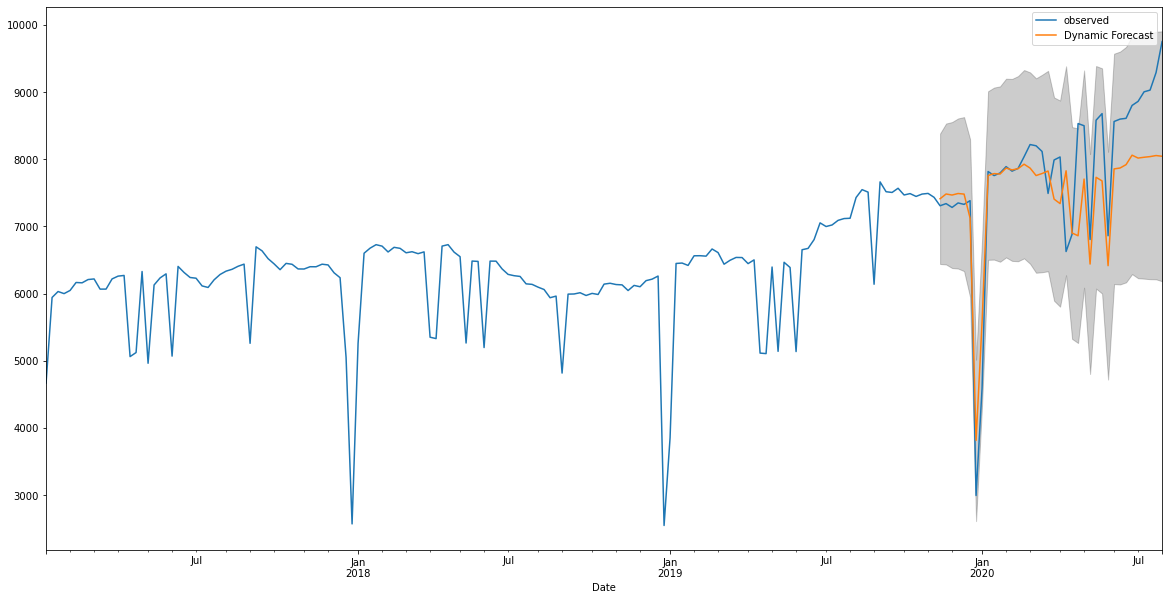

*** RMSE of SARIMA with season_length=52 and dynamic = False  --> 504.81


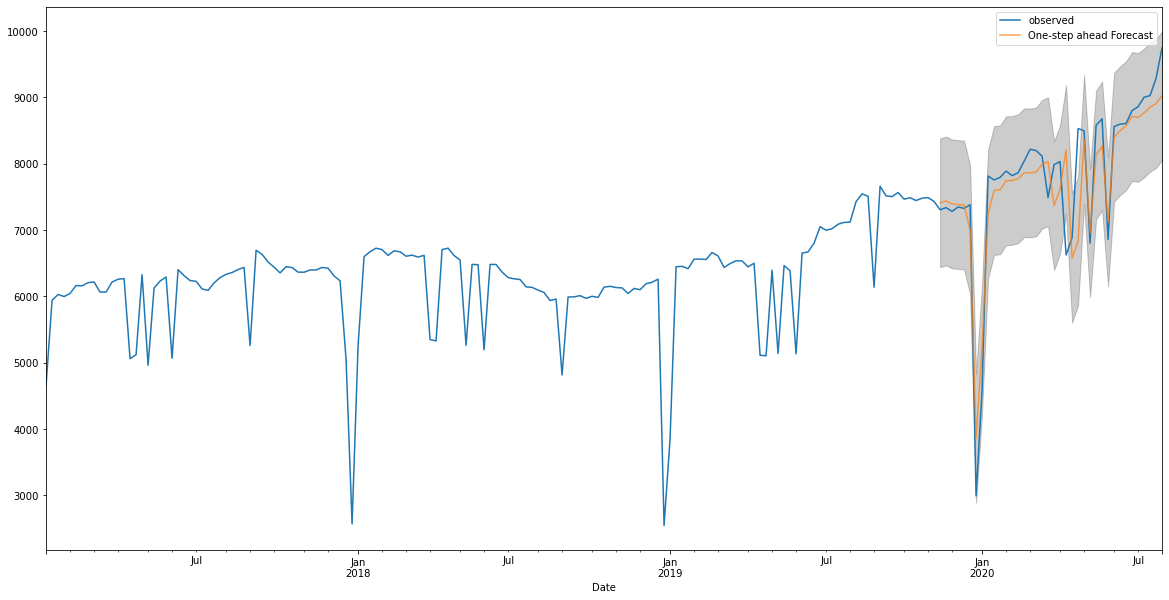

In [21]:
model = evaluate_sarima(y,(1, 1, 1),(1, 1, 0, 52),52,'2019-11-17',y_to_test)

### Interpreting SARIMA Results

#### In addition Root Mean Squared Error (RMSE) metric, we performed a couple of other steps to evaluate our model's fit. We ran the plot_diagnostics() function on our model, which returns 4 common plots that show if the model is a good fit to our data.

#### The four plots returned are:
 - Standardized residual: This will show whether or not there are obvious patterns in the residuals. Judging by how "messy" the lines are, we can confidendly say we found the major signals (i.e. trend and seasonality components) in our time series and that we have cleaned out most of the "noise".
 - Histogram plus kde estimate: The KDE curve should be very similar to the normal distribution. We see this clearly in our plot. This indicates we have found good-fit model for our dataset.
 - Normal Q-Q: If most of our data points lies on the straight line, then our model is a good fit.
 - Correlogram: Ideally, 95% of correlations for lag greater than zero should not be significant. As we can see, most of  the dots are within the confidence band (blue shaded area). This means that the residuals have low correlations with its lagged version. This shows that we have a good fit. 

#### Finally, we have a model that produces the best fit! Compared with the the previous models, we can confidently say the SARIMA model (with dynamic=false) best captures both the seasonality and trend of our dataset. Its forecasted results are closest to the actual gold prices for the time period of interest.

# PART THREE: TIME SERIES FORECASTING

## Making Predictions
#### Now that we have found the best-fitted model, we are ready to do some time series forecasting. We will be predicting the price of gold for the next year, therefore, the forecast() method will be passed the parameter steps=52. 

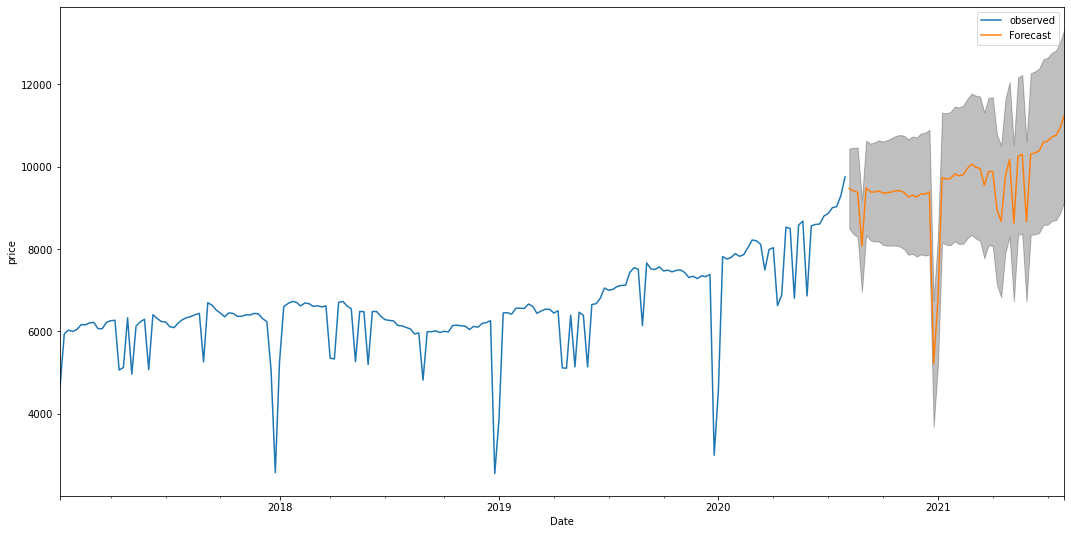

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2020-08-09,9468.83898873,8497.81738482,10439.86059265
1,2020-08-16,9412.60883566,8363.46541676,10461.75225457
2,2020-08-23,9376.68318925,8289.96390123,10463.40247728
3,2020-08-30,8075.38326908,6957.84056484,9192.92597332
4,2020-09-06,9484.38739408,8337.86194261,10630.91284555


In [22]:
pred_uc = model.get_forecast(steps=52)
print(pred_uc)
pred_ci = pred_uc.conf_int() #this uses the default alpha of .05 which returns a 95% confidence interval...
predicted_vals = pred_uc.predicted_mean
ax = y.plot(label='observed', figsize=(18, 9))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel(y.name)

plt.legend()
plt.show()
    
# Produce the forcasted tables 
pm = pred_uc.predicted_mean.reset_index()
pm.columns = ['Date','Predicted_Mean']
pci = pred_ci.reset_index()
pci.columns = ['Date','Lower Bound','Upper Bound']
_table = pm.join(pci.set_index('Date'), on='Date')
_table.head()

#### Above is the prediction graph and an output table depicting the predicted mean as well as the upper and lower bounds of our predictions. We can clearly see from the graph that our model sufficiently captured the trends and seasonality compoments of our time series data as shown by the increasing trends as well as the yearly seasonal dip.

##### The orange line shows the expected future gold prices (based on our forecasting model). Barring any random or irregular variations, we expect the actual numbers to follow this line. The gray area is the 95% confidence interval indicating that we are 95% confident that the actual gold prices will fall within this range. As is the case with most forecasting models, our confidence levels are expected to start dropping the further into the future the prediction goes. The bigger the future forecasted time the larger the confidence interval will be (i.e. the less precise our forecast will be). 

### Comparing our future Prediction to Actuals

#### Our model predicted gold prices for 52 weeks into the future from 2020-08 to 2021-08-01. Luckily, we have actual, real life gold prices for 36 of those 52 weeks! We will plot a graph of these 2 time series data and see how well our predictions matches the actual dataset.

In [23]:
#predictions print out
predicted_vals

2020-08-09    9468.83898873
2020-08-16    9412.60883566
2020-08-23    9376.68318925
2020-08-30    8075.38326908
2020-09-06    9484.38739408
2020-09-13    9386.59995085
2020-09-20    9385.28955259
2020-09-27    9413.82298709
2020-10-04    9356.61151559
2020-10-11    9365.24860517
2020-10-18    9387.44378004
2020-10-25    9415.40126998
2020-11-01    9415.57646782
2020-11-08    9374.83212826
2020-11-15    9262.76903290
2020-11-22    9309.34097119
2020-11-29    9264.48393599
2020-12-06    9339.21895376
2020-12-13    9332.16143891
2020-12-20    9384.72937936
2020-12-27    5216.46556954
2021-01-03    6718.16056244
2021-01-10    9737.71270009
2021-01-17    9698.68937155
2021-01-24    9713.60344195
2021-01-31    9824.06599431
2021-02-07    9779.00074061
2021-02-14    9804.79958897
2021-02-21    9956.20320213
2021-02-28   10060.65694188
2021-03-07    9991.56335256
2021-03-14    9953.80124944
2021-03-21    9547.67176957
2021-03-28    9881.80860605
2021-04-04    9882.47497850
2021-04-11    8954.4

In [24]:
pred = predicted_vals[1:36]

In [25]:
df1 = pd.read_csv("gold_price_2021.csv")
df1['date'] = pd.to_datetime(df1['date'])
df1 = df1.set_index('date')
df1 = df1['2020-08-03':'2021-04-07'].resample('W').sum()
print('size of data -->',df1.size)

size of data --> 36


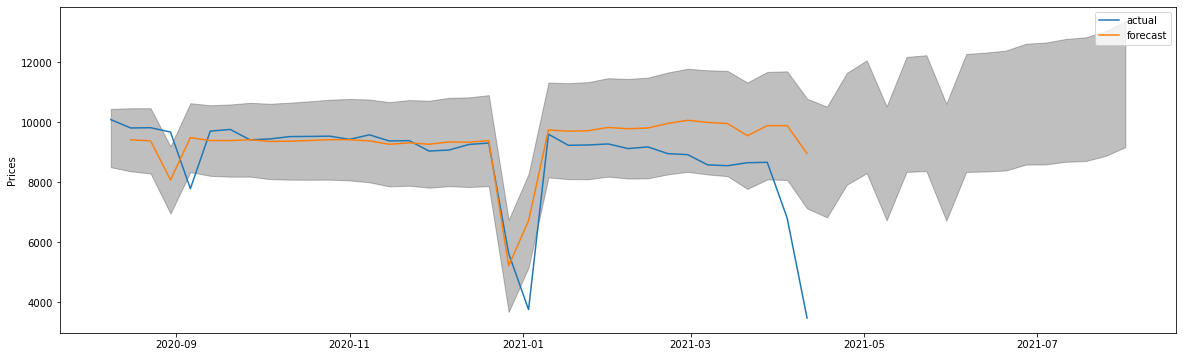

In [26]:
y1 = df1['price']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y1, label='actual')
ax.plot(predicted_vals[1:36], label='forecast') #clipping to first 36 values to match the size of our actual data
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_ylabel('Prices')
ax.legend();

#### As we can see, our model was performed really well in predicting values that closely matched the actual values up till around April 2021, when we see a actual gold prices make a drastic and sharp drop out of our confidence range. This was an expected turn of events, which is often referred to as a RANDOM or IRREGULAR variation in the time series. In this case, we know the real-world reason for this:COVID-19! The global pandemic and the rise in inflation rates are <i>noises</i> that negatively affected the price of commodities like gold which is what we see in the graph above. As this was an unexpected and unanticipated outcome, our model was unable to account for it in it's predictions.

#### Random or irregular fluctuations are an arbitrary variation that cannot really be foreseen or predicted, because each data point of these random fluctuations is independent of the trends and seasonality components of our data. Hence, our forecasting model was unable to account for thit in it's predictions.

##### For this reason, when sharing the forecasts with stakeholders, it is important to manage expectations. Results from a forecasting model cannot be seen as guaranteed, but only as a guiding reference of future patterns barring any drastic or unexpected events like the sudden onset of COVID-19 which had huge negative global impacts on gold prices.

# 

# THE END